# Obtaining Statistics of the RoomNav dataset

1. Average Geodesic Distances
2. Histogram of distances vs episodes
3. Average of top-down maps
4. Lenght of oracle

2019-06-27 09:20:51,150 initializing sim Sim-v0
2019-06-27 09:20:53,422 initializing task Nav-v0


SPLIT:  train
Average Euclidean Distance:  9.285327902764505
Max Euclidean Distance:  44.632583699229166
Min Euclidean Distance:  0.5016472249430431
Average Geodesic Distance:  11.990662969581122
Max Geodesic Distance:  52.74478530883789
Min Geodesic Distance:  1.0001815557479858


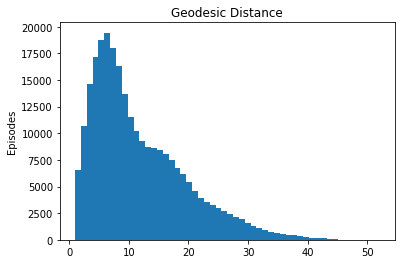

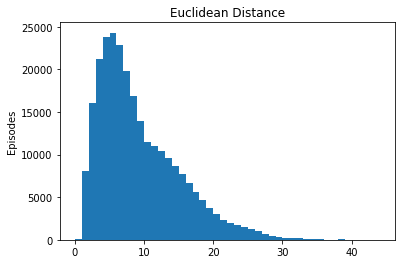

AttributeError: 'Text' object has no property 'bins'

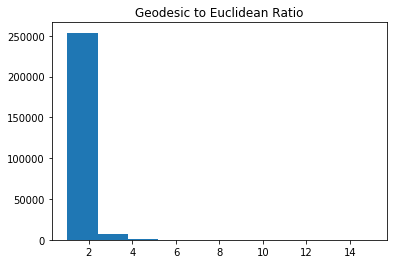

In [8]:
import habitat

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

splits = ['train', 'test', 'val']

data_path = '../data/datasets/roomnav/mp3d/v1/{split}/{split}.json.gz'

for split in splits:
    
    avg_gd = 0
    avg_ed = 0
    min_gd = 10000000000
    max_gd = 0
    min_ed = 10000000000
    max_ed = 0
    
    gd_dists = []
    ed_dists = []
    gd2ed = []

    config = habitat.get_config(config_paths='../configs/tasks/roomnav_mp3d.yaml')
    config.defrost()
    config.DATASET.DATA_PATH = data_path.format(split=split)
    config.DATASET.SCENES_DIR = '../data/scene_datasets/'
    config.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR', 'SEMANTIC_SENSOR']
    config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = 256
    config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = 256
    config.SIMULATOR.TURN_ANGLE = 30
    config.freeze()
    

    env = habitat.Env(config=config)

    for i in range(len(env.episodes)):
        observations = env.reset()
      
        sp = env.episodes[i].start_position
        tp = env.episodes[i].goals[0].position
        
        gd = env.sim.geodesic_distance(sp, tp)
        ed = np.power(np.power(np.array(sp) - np.array(tp), 2).sum(0), 0.5)
        
        gd2ed.append(gd/ed)
        gd_dists.append(gd)
        ed_dists.append(ed)

    env.close()
    
    ed_dists = np.asarray(ed_dists)
    gd_dists = np.asarray(gd_dists)
    gd2ed = np.asarray(gd2ed)
    
    print('SPLIT: ', split)
    print('Average Euclidean Distance: ', np.mean(ed_dists))
    print('Max Euclidean Distance: ', np.max(ed_dists))
    print('Min Euclidean Distance: ', np.min(ed_dists))
    
    print('Average Geodesic Distance: ', np.mean(gd_dists))
    print('Max Geodesic Distance: ', np.max(gd_dists))
    print('Min Geodesic Distance: ', np.min(gd_dists))
    
    plt.hist(gd_dists.astype(int), bins=int(np.max(gd_dists)))
    plt.title("Geodesic Distance")
    plt.ylabel('Episodes')
    plt.show()

    plt.hist(ed_dists.astype(int), bins=int(np.max(ed_dists)))
    plt.title("Euclidean Distance")
    plt.ylabel('Episodes')
    plt.show()
    
    plt.hist(np.around(gd2ed, decimals=2), bins=1000)
    plt.title("Geodesic to Euclidean Ratio")
    plt.ylabel('Episodes')
    plt.show()
    

In [9]:
'''Oracle Path Lengths'''

import habitat_sim
import json
import gzip
from pydash import py_
import numpy as np
import tqdm
import glob

splits = ['train', 'test', 'val']

data_path = '../data/datasets/roomnav/mp3d/v1/{split}/{split}_all.json.gz'

for split in splits:
    with gzip.open(data_path.format(split=split), "rt") as f:
        episodes = json.load(f)["episodes"]

    act_path_lens = []
    for scene_id, eps in tqdm.tqdm(py_.group_by(episodes, "scene_id").items()):
        agent_cfg = habitat_sim.AgentConfiguration()
        sim_cfg = habitat_sim.SimulatorConfiguration()
        sim_cfg.scene.id = scene_id
        sim = habitat_sim.Simulator(
            habitat_sim.Configuration(sim_cfg, [agent_cfg])
        )

        for ep in tqdm.tqdm(eps, leave=False):
            state = sim.get_agent(0).state
            state.position = ep["start_position"]
            state.rotation = ep["start_rotation"]
            state.sensor_states = dict()

            sim.get_agent(0).state = state

            act_path_lens.append(
                len(
                    sim.make_greedy_follower().find_path(
                        ep["goals"][0]["position"]
                    )
                )
            )


    act_path_lens = np.array(act_path_lens)
    
    print('SPLIT: ', split)
    print("Min=", np.min(act_path_lens))
    print("Mean=", np.mean(act_path_lens))
    print("Median=", np.median(act_path_lens))
    print("Max=", np.max(act_path_lens))

ModuleNotFoundError: No module named 'pydash'

In [10]:
import numpy as np

a = np.array([1.2213,1.213213,12.23,123.2,12,23.2324])

In [11]:
a

array([  1.2213  ,   1.213213,  12.23    , 123.2     ,  12.      ,
        23.2324  ])

In [12]:
np.around(a, decimals=2)

array([  1.22,   1.21,  12.23, 123.2 ,  12.  ,  23.23])